In [2]:
#%matplotlib notebook

import re

import gemmi
import numpy as np
import reciprocalspaceship as rs
from glob import glob
from natsort import natsorted

from scipy.stats import differential_entropy
from scipy.stats import kurtosis
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt

import masks

In [3]:
def negentropy(X):
    """
    Return negentropy (float) of X (numpy array)
    """
    
    # negetropy is the difference between the entropy of samples x
    # and a Gaussian with same variance
    # http://gregorygundersen.com/blog/2020/09/01/gaussian-entropy/
    
    std = np.std(X)
    #neg_e = np.log(std*np.sqrt(2*np.pi*np.exp(1))) - differential_entropy(X)
    neg_e = 0.5 * np.log(2.0 * np.pi * std ** 2) + 0.5 - differential_entropy(X)
    #assert neg_e >= 0.0
    
    return neg_e


def mtz_to_stats(mtz_path, weight, labf='KFOFOWT', labphi='PHIKFOFOWT', masked=True):
    
    mtz = gemmi.read_mtz_file(mtz_path)
    grid = mtz.transform_f_phi_to_map(labf, labphi, sample_rate=3)
    if masked:
        grid = masks.FDA_and_TT_chainA_region_only(grid)

    x = np.array(grid).flatten()
    x = x[x != 0.0]

    return np.array([weight, negentropy(x), kurtosis(x)])


def wilson(dataset, Flab, bins=100):

    dataset['d'] = dataset.compute_dHKL()['dHKL']
    dataset = dataset[['d', Flab]]
    dataset = dataset.dropna(how='any')

    values, edges, _ = binned_statistic((1.0/ds['d'])**2, ds[Flab] ** 2, bins=bins)
    bin_centers = (edges[1:] + edges[:-1]) / 2.0

    values[values <= 0.0] = 1e-32

    return values, bin_centers

In [4]:
basedir = '/Users/tjlane/Desktop/PL-workshop/weighting-optimization/ded-kweight-test/'

no_weight_mtz = basedir + '3ns-dark_noW_FoFo.mtz'
q_weight_mtz  = basedir + '3ns-dark_qFoFo.mtz'
k_weight_mtzs = glob(basedir + '3ns-dark_k*_mkFoFo.mtz')

In [5]:
kwt_stats = np.zeros((len(k_weight_mtzs) + 2, 3))

kwt_stats[0,:] = mtz_to_stats(no_weight_mtz, -0.1, 'FOFOWT', 'PHIFOFOWT', masked=False)
kwt_stats[1,:] = mtz_to_stats(q_weight_mtz, 0.0, 'QFOFOWT', 'PHIQFOFOWT', masked=False)

for i,kw_mtz in enumerate(k_weight_mtzs):
    g = re.search(r'3ns-dark_k(\d+)p(\d+)_mkFoFo.mtz', kw_mtz)
    k_wt = float(g.group(1) + '.' +g.group(2))
    kwt_stats[i+2,:] = mtz_to_stats(kw_mtz, k_wt, masked=False)

kwt_stats = kwt_stats[np.argsort(kwt_stats[:,0]),:]

In [6]:
kwt_stats_masked = np.zeros((len(k_weight_mtzs) + 2, 3))

kwt_stats_masked[0,:] = mtz_to_stats(no_weight_mtz, -0.1, 'FOFOWT', 'PHIFOFOWT', masked=True)
kwt_stats_masked[1,:] = mtz_to_stats(q_weight_mtz, 0.0, 'QFOFOWT', 'PHIQFOFOWT', masked=True)

for i,kw_mtz in enumerate(k_weight_mtzs):
    g = re.search(r'3ns-dark_k(\d+)p(\d+)_mkFoFo.mtz', kw_mtz)
    k_wt = float(g.group(1) + '.' +g.group(2))
    kwt_stats_masked[i+2,:] = mtz_to_stats(kw_mtz, k_wt, masked=True)

kwt_stats_masked = kwt_stats_masked[np.argsort(kwt_stats_masked[:,0]),:]

/var/folders/s9/bht_sc9n7ys6m0q3h_3htntc0000gn/T/ipykernel_93000/1967205934.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(121)


<Figure size 640x480 with 0 Axes>

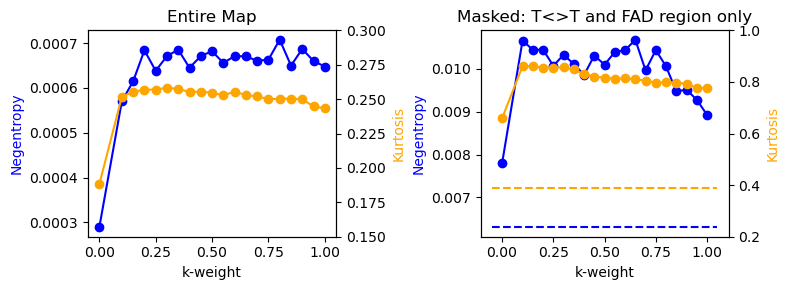

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure(figsize=(8,3))
plt.title('mask - TT region')

ax = plt.subplot(121)
ax.set_title('Entire Map')
p1 = ax.plot(kwt_stats[1:,0], kwt_stats[1:,1], color='blue')
ax.plot(kwt_stats[1:,0], kwt_stats[1:,1], 'o', color='blue')
#ax.hlines(kwt_stats_masked[0,1], -0.05, 1.05, linestyle='--', color='blue')

plt.xlabel(r'k-weight')
ax.set_ylabel('Negentropy', color='blue')

ax2 = ax.twinx()
p2 = ax2.plot(kwt_stats[1:,0], kwt_stats[1:,2], color='orange')
ax2.plot(kwt_stats[1:,0], kwt_stats[1:,2], 'o', color='orange')
ax2.set_ylabel('Kurtosis', color='orange')
#ax2.hlines(kwt_stats[0,2], -0.05, 1.05, linestyle='--', color='orange')
ax2.set_ylim([0.15, 0.3])

ax = plt.subplot(122)
ax.set_title('Masked: T<>T and FAD region only')
p1 = ax.plot(kwt_stats_masked[1:,0], kwt_stats_masked[1:,1], color='blue')
ax.plot(kwt_stats_masked[1:,0], kwt_stats_masked[1:,1], 'o', color='blue')
ax.hlines(kwt_stats_masked[0,1], -0.05, 1.05, linestyle='--', color='blue')


plt.xlabel(r'k-weight')
ax.set_ylabel('Negentropy', color='blue')

ax2 = ax.twinx()
p2 = ax2.plot(kwt_stats_masked[1:,0], kwt_stats_masked[1:,2], color='orange')
ax2.plot(kwt_stats_masked[1:,0], kwt_stats_masked[1:,2], 'o', color='orange')
ax2.hlines(kwt_stats_masked[0,2], -0.05, 1.05, linestyle='--', color='orange')
ax2.set_ylim([0.2,1.0])
ax2.set_ylabel('Kurtosis', color='orange')

plt.tight_layout()
# plt.savefig('k-weighting.pdf')
# plt.savefig('k-weighting.png')
# plt.savefig('k-weighting.eps')
plt.figure()

## wilson plot

In [8]:
wilson_dir = '/Users/tjlane/Desktop/PL-workshop/weighting-optimization/extr-weight-test/'

wilson_datasets = [
    ('no weights', '3ns-dark_noW_extr_occ0.080_Fextr.mtz', 'FEXTR'),
    ('q weights', '3ns-dark_q_extr_occ0.080_qFextr.mtz', 'QFEXTR'),
    ('k=0.05', '3ns-dark_k0p05_extr_occ0.080_kFextr.mtz', 'KFEXTR'),
    ('k=0.50', '3ns-dark_k0p5_extr_occ0.080_kFextr.mtz', 'KFEXTR'),
    ('k=1.00', '3ns-dark_k1p0_extr_occ0.080_kFextr.mtz', 'KFEXTR'),
]

In [9]:
wilson_expntl = lambda d_sq, A, B : A * np.exp(-1 * B * d_sq)

In [10]:
plt.figure(figsize=(4.5,18))

for iw, wilson_dataset in enumerate(wilson_datasets):

    ax = plt.subplot(len(wilson_datasets), 1, iw+1)

    ds = rs.read_mtz(wilson_dir + wilson_dataset[1])
    Flab = wilson_dataset[2]

    v, bc = wilson(ds, Flab)

    ax.plot((1.0/ds['d']) ** 2, ds[Flab] ** 2, '.', color='grey', markersize=0.5)
    ax.plot(bc, v, linewidth=5)

    p_opt, _ = curve_fit(wilson_expntl, bc, v, p0=(10, 1000))
    ax.plot(bc, wilson_expntl(bc, *p_opt))

    ax.set_yscale('symlog')
    ax.set_xlabel('d$^2$')
    ax.set_ylabel(f'|F|$^2$')

    ax.set_xlim([0, 0.185])
    ax.set_ylim([1e4, 1e7])

    ax.legend(title=wilson_dataset[0])

    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xticklabels( [f'{t: .1f}' for t in 1.0/np.sqrt(ax.get_xticks())] )
    ax2.set_xlabel(r"Resolution (A)")

plt.tight_layout()
plt.savefig(wilson_dir + '../weighted_wilson_plots.pdf')
plt.savefig(wilson_dir + '../weighted_wilson_plots.png')
plt.show()

/var/folders/s9/bht_sc9n7ys6m0q3h_3htntc0000gn/T/ipykernel_93000/1590407958.py:1: RuntimeWarning: overflow encountered in exp
  wilson_expntl = lambda d_sq, A, B : A * np.exp(-1 * B * d_sq)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/s9/bht_sc9n7ys6m0q3h_3htntc0000gn/T/ipykernel_93000/931317132.py:30: RuntimeWarning: divide by zero encountered in divide
  ax2.set_xticklabels( [f'{t: .1f}' for t in 1.0/np.sqrt(ax.get_xticks())] )
/var/folders/s9/bht_sc9n7ys6m0q3h_3htntc0000gn/T/ipykernel_93000/1590407958.py:1: RuntimeWarning: overflow encountered in exp
  wilson_expntl = lambda d_sq, A, B : A * np.exp(-1 * B * d_sq)
/var/folders/s9/bht_sc9n7ys6m0q3h_3htntc0000gn/T/ipykernel_93000/1590407958.py:1: RuntimeWarning: overflow encountered in multiply
  wilson_expntl = lambda d_sq, A, B : A * np.exp(-1 * B * d_sq)
No artists with labels found to put in legend.  Note tha